In [79]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

########## load data start
data_path = '../csv/3rd-ml100marathon-midterm/'
df_train_tmp = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

########## load data start end


# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
def plot(plot_datas):
    plot_datas_new = plot_datas.copy()
    plt.figure(figsize = (24, 8))
    feat_labels = plot_datas_new.columns
    print('feat_labels ', feat_labels)
# 依不同 EXT_SOURCE 逐項繪製 KDE 圖形
    for i, source in enumerate(feat_labels):
        if source == 'poi':
            continue
            
        source_array = [source,'poi']
        var_plot_data = plot_datas_new[source_array]
        print('######################################################################')
        print('describe : ', var_plot_data[source].describe())
        var_plot_data = var_plot_data.dropna()

        q25, q75 = np.percentile(var_plot_data[source], 25), np.percentile(var_plot_data[source], 75)
        iqr = q75 - q25
        print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
        # calculate the outlier cutoff
        cut_off = iqr * 3
        lower, upper = q25 - cut_off, q75 + cut_off
        # identify outliers
        outliers = [x for x in var_plot_data[source] if x < lower or x > upper]
        print('Identified outliers: %d' % len(outliers))
        # remove outliers
        outliers_removed = [x for x in var_plot_data[source] if x >= lower and x <= upper]
        print('Non-outlier observations: %d' % len(outliers_removed))
        print('feat_label ', source)
        # KDE 圖形
        sns.kdeplot(var_plot_data.loc[var_plot_data['poi'] == False, source], label = 'poi == 0')
        sns.kdeplot(var_plot_data.loc[var_plot_data['poi'] == True, source], label = 'poi == 1')
        
        # 加上各式圖形標籤
        plt.title('Distribution of %s by Target Value' % source)
        plt.xlabel('%s' % source); plt.ylabel('Density');
        plt.show()
        #######
        var_plot_data_outlier_removed = var_plot_data.loc[(var_plot_data[source]>= lower) & (var_plot_data[source] <= upper)]
        sns.kdeplot(var_plot_data_outlier_removed.loc[var_plot_data_outlier_removed['poi'] == False, source], label = 'poi == 0')
        sns.kdeplot(var_plot_data_outlier_removed.loc[var_plot_data_outlier_removed['poi'] == True, source], label = 'poi == 1')
        
        # 加上各式圖形標籤
        plt.title('Distribution of %s by Target Value' % source)
        plt.xlabel('%s' % source); plt.ylabel('Density');
        plt.show()
        
        ########
        var_plot_data_2 = var_plot_data
        var_plot_data_2[source] = var_plot_data[source].clip(lower, upper)
        sns.kdeplot(var_plot_data_2.loc[var_plot_data_2['poi'] == False, source], label = 'poi == 0')
        sns.kdeplot(var_plot_data_2.loc[var_plot_data_2['poi'] == True, source], label = 'poi == 1')
        
        # 加上各式圖形標籤
        plt.title('Distribution of %s by Target Value' % source)
        plt.xlabel('%s' % source); plt.ylabel('Density');
        plt.show()


########## 前處理理 (Processing) start
#薪水
var_salary = ['salary']

#獎金
var_bonus = ['bonus']

#業務報銷
var_business_expenses_group = ['long_term_incentive','deferred_income','loan_advances'
        ,'deferral_payments','other','expenses']

#董事费
var_director_fees = ['director_fees']

#總支出
var_total_payments = ['total_payments']

#股權
var_10_11_12 = ['exercised_stock_options','restricted_stock','restricted_stock_deferred']

#股權 total
var_total_stock_value = ['total_stock_value']

#email回覆
var_email_count_group = ['to_messages','from_poi_to_this_person','from_messages','from_this_person_to_poi','shared_receipt_with_poi']


df_train_tmp = df_train_tmp.drop(['name', 'email_address'] , axis=1)

df_train_tmp = df_train_tmp.drop(['director_fees'] , axis=1)
df_train_tmp = df_train_tmp.drop(['restricted_stock_deferred'] , axis=1)
df_train_tmp = df_train_tmp.drop(['loan_advances'] , axis=1)


feat_labels = df_train_tmp.columns
feat_labels

########## 前處理理 (Processing) end



Index(['bonus', 'deferral_payments', 'deferred_income',
       'exercised_stock_options', 'expenses', 'from_messages',
       'from_poi_to_this_person', 'from_this_person_to_poi',
       'long_term_incentive', 'other', 'poi', 'restricted_stock', 'salary',
       'shared_receipt_with_poi', 'to_messages', 'total_payments',
       'total_stock_value'],
      dtype='object')

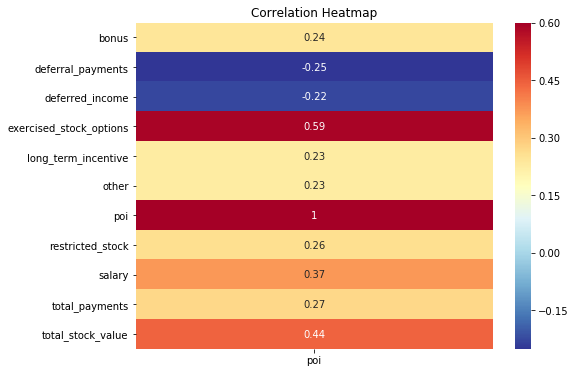

In [77]:
ext_data_corrs = df_train_tmp.corr()

threshold = 0.2
threshold2 = -1*threshold
ext_data_corrs = ext_data_corrs.loc[:, ['poi']]

ext_data_corrs = ext_data_corrs.loc[(ext_data_corrs['poi']>threshold) | (ext_data_corrs['poi']<threshold2)]
ext_data_corrs_index = ext_data_corrs.index

plt.figure(figsize = (8, 6))
# 繪製相關係數 (correlations) 的 Heatmap
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

In [37]:
df_train_tmp[ext_data_corrs_index].head()


,bonus,deferral_payments,deferred_income,exercised_stock_options,long_term_incentive,other,poi,restricted_stock,salary,total_payments,total_stock_value
0,1750000.0,NaN,-3504386.0,19794175.0,1617011.0,174839.0,True,2748364.0,420636.0,505050.0,22542539.0
1,5600000.0,NaN,NaN,19250000.0,1920000.0,22122.0,True,6843672.0,1111258.0,8682716.0,26093672.0
2,200000.0,NaN,-4167.0,1624396.0,NaN,1573324.0,True,869220.0,211844.0,2003885.0,2493616.0
3,800000.0,NaN,NaN,NaN,602671.0,907502.0,True,985032.0,224305.0,2652612.0,985032.0
4,1250000.0,NaN,-262500.0,NaN,375304.0,486.0,True,126027.0,240189.0,1639297.0,126027.0


feat_labels  Index(['bonus', 'deferral_payments', 'deferred_income',
       'exercised_stock_options', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'salary', 'total_payments', 'total_stock_value'],
      dtype='object')
######################################################################
describe :  count    6.100000e+01
mean     1.147436e+06
std      1.505189e+06
min      7.000000e+04
25%      4.500000e+05
50%      7.500000e+05
75%      1.000000e+06
max      8.000000e+06
Name: bonus, dtype: float64
Percentiles: 25th=450000.000, 75th=1000000.000, IQR=550000.000
Identified outliers: 6
Non-outlier observations: 55
feat_label  bonus


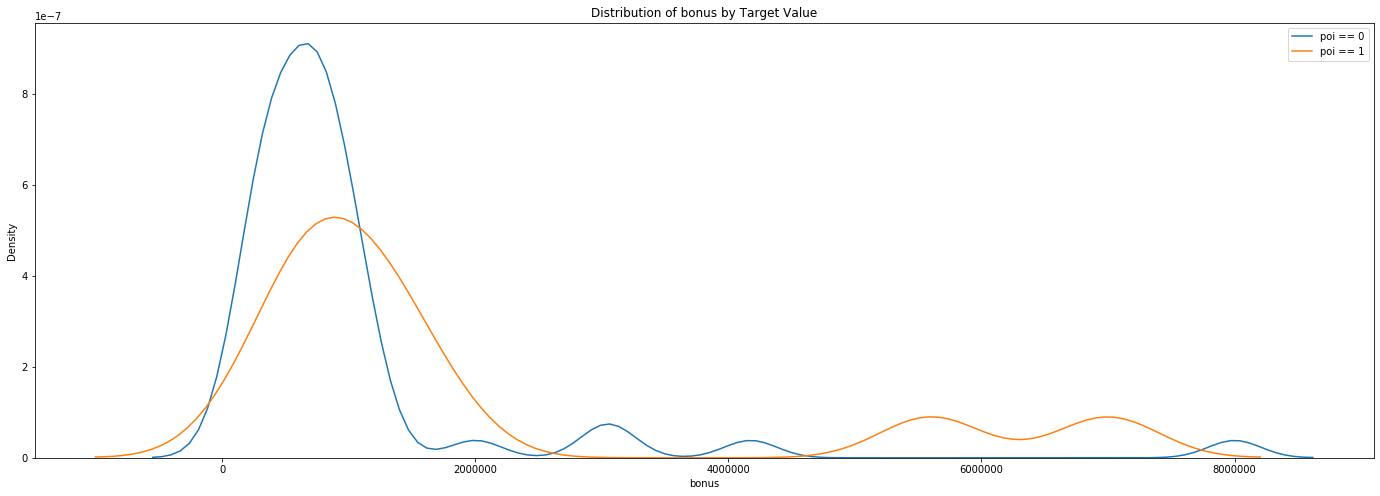

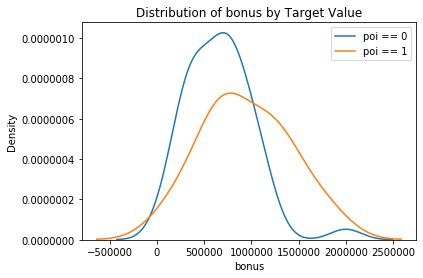

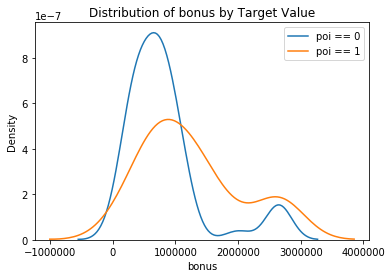

######################################################################
describe :  count    2.800000e+01
mean     6.344374e+05
std      8.603646e+05
min     -1.025000e+05
25%      7.656750e+04
50%      1.951900e+05
75%      8.342052e+05
max      2.964506e+06
Name: deferral_payments, dtype: float64
Percentiles: 25th=76567.500, 75th=834205.250, IQR=757637.750
Identified outliers: 0
Non-outlier observations: 28
feat_label  deferral_payments


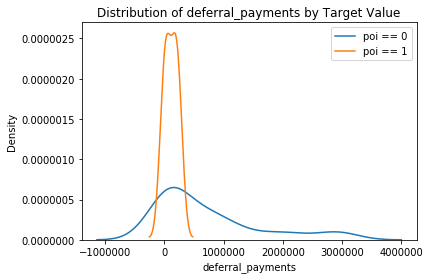

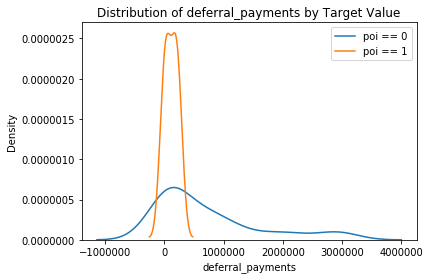

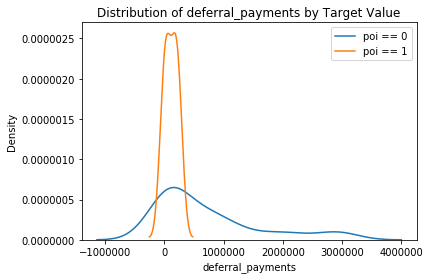

######################################################################
describe :  count    3.400000e+01
mean    -4.625664e+05
std      8.095392e+05
min     -3.504386e+06
25%     -5.527032e+05
50%     -1.175340e+05
75%     -2.708325e+04
max     -1.042000e+03
Name: deferred_income, dtype: float64
Percentiles: 25th=-552703.250, 75th=-27083.250, IQR=525620.000
Identified outliers: 2
Non-outlier observations: 32
feat_label  deferred_income


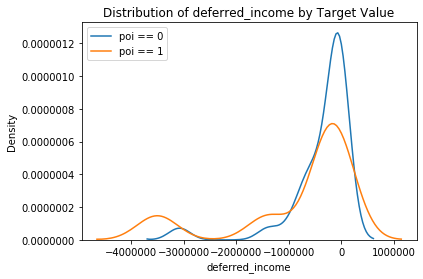

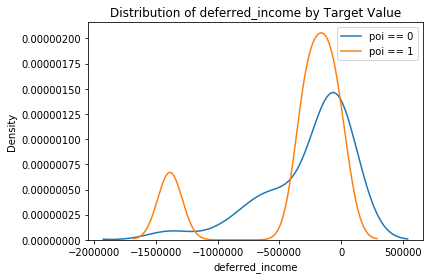

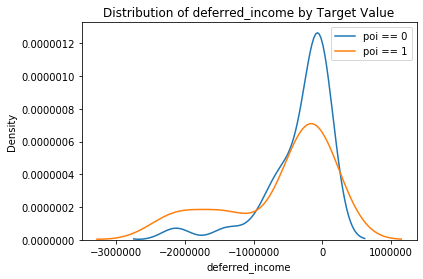

######################################################################
describe :  count    8.100000e+01
mean     2.985081e+06
std      6.004174e+06
min      3.285000e+03
25%      4.004780e+05
50%      8.500100e+05
75%      2.165172e+06
max      3.434838e+07
Name: exercised_stock_options, dtype: float64
Percentiles: 25th=400478.000, 75th=2165172.000, IQR=1764694.000
Identified outliers: 8
Non-outlier observations: 73
feat_label  exercised_stock_options


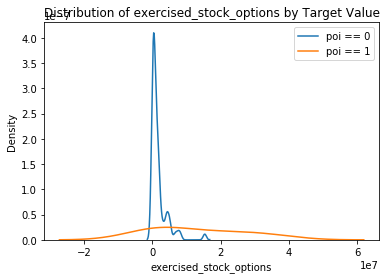

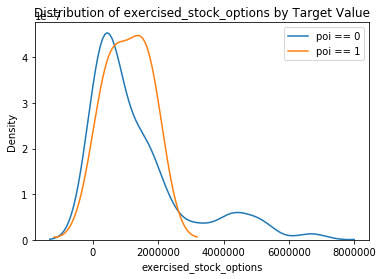

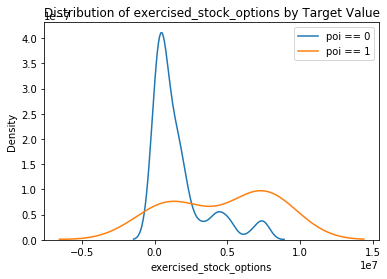

######################################################################
describe :  count    4.900000e+01
mean     7.926171e+05
std      9.504645e+05
min      7.102300e+04
25%      2.750000e+05
50%      4.221580e+05
75%      8.318090e+05
max      5.145434e+06
Name: long_term_incentive, dtype: float64
Percentiles: 25th=275000.000, 75th=831809.000, IQR=556809.000
Identified outliers: 2
Non-outlier observations: 47
feat_label  long_term_incentive


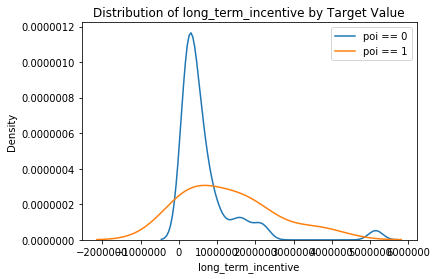

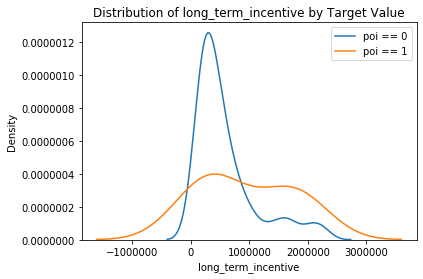

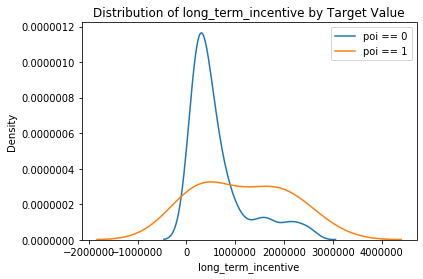

######################################################################
describe :  count    6.900000e+01
mean     4.471774e+05
std      1.341564e+06
min      2.000000e+00
25%      9.720000e+02
50%      5.238200e+04
75%      3.620960e+05
max      1.035973e+07
Name: other, dtype: float64
Percentiles: 25th=972.000, 75th=362096.000, IQR=361124.000
Identified outliers: 6
Non-outlier observations: 63
feat_label  other


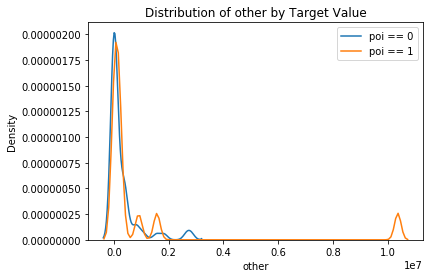

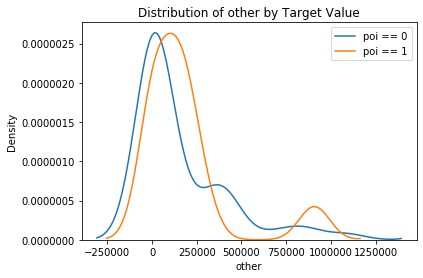

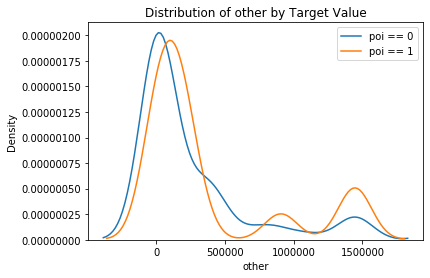

######################################################################
describe :  count    8.200000e+01
mean     1.294855e+06
std      2.498335e+06
min      4.409300e+04
25%      2.689220e+05
50%      4.628225e+05
75%      9.664905e+05
max      1.476169e+07
Name: restricted_stock, dtype: float64
Percentiles: 25th=268922.000, 75th=966490.500, IQR=697568.500
Identified outliers: 8
Non-outlier observations: 74
feat_label  restricted_stock


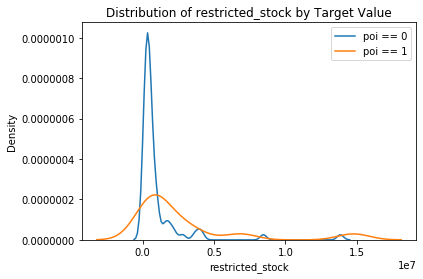

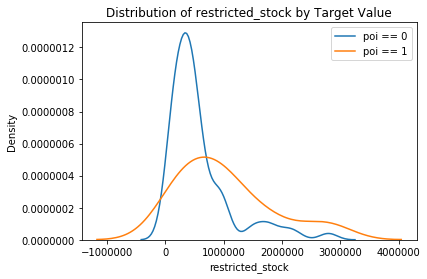

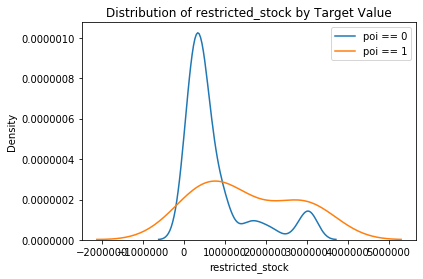

######################################################################
describe :  count    7.300000e+01
mean     2.739025e+05
std      1.716647e+05
min      4.770000e+02
25%      2.061210e+05
50%      2.516540e+05
75%      2.885890e+05
max      1.111258e+06
Name: salary, dtype: float64
Percentiles: 25th=206121.000, 75th=288589.000, IQR=82468.000
Identified outliers: 3
Non-outlier observations: 70
feat_label  salary


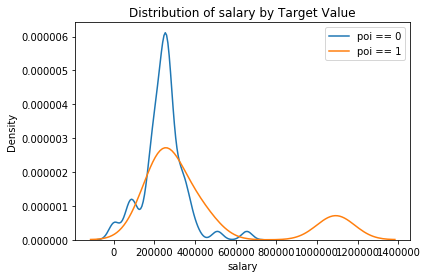

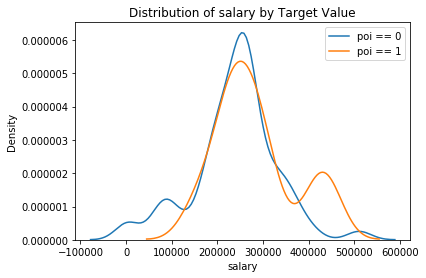

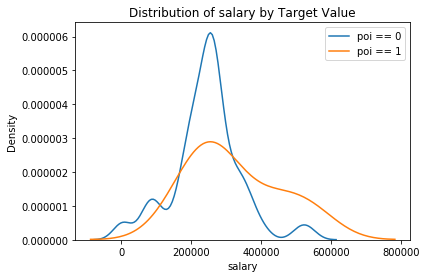

######################################################################
describe :  count    9.600000e+01
mean     2.590977e+06
std      1.056645e+07
min      1.480000e+02
25%      3.024025e+05
50%      1.106740e+06
75%      1.985668e+06
max      1.035598e+08
Name: total_payments, dtype: float64
Percentiles: 25th=302402.500, 75th=1985668.250, IQR=1683265.750
Identified outliers: 4
Non-outlier observations: 92
feat_label  total_payments


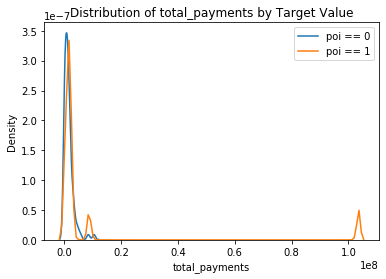

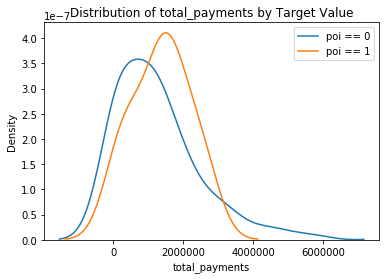

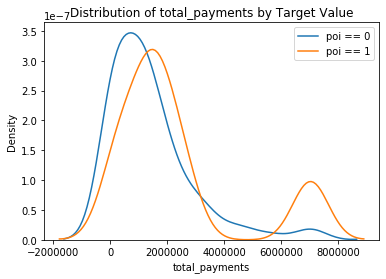

######################################################################
describe :  count    9.800000e+01
mean     3.527136e+06
std      7.182997e+06
min     -4.409300e+04
25%      4.211518e+05
50%      9.979710e+05
75%      2.493616e+06
max      4.911008e+07
Name: total_stock_value, dtype: float64
Percentiles: 25th=421151.750, 75th=2493616.000, IQR=2072464.250
Identified outliers: 8
Non-outlier observations: 90
feat_label  total_stock_value


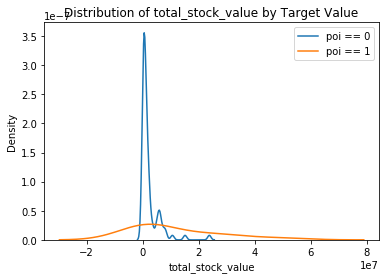

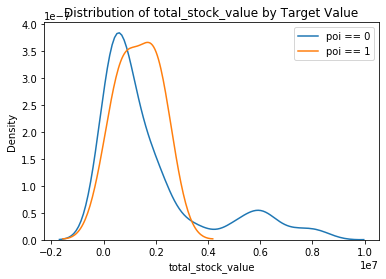

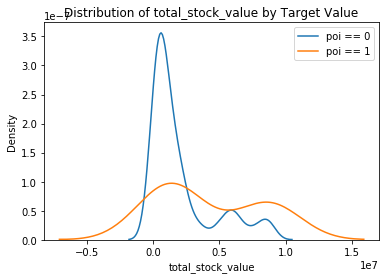

In [80]:
df_train_tmp[ext_data_corrs_index]
plot(df_train_tmp[ext_data_corrs_index])

In [75]:
ext_data_corrs_index

Index(['bonus', 'deferral_payments', 'deferred_income',
       'exercised_stock_options', 'long_term_incentive', 'other', 'poi',
       'restricted_stock', 'salary', 'total_payments', 'total_stock_value'],
      dtype='object')

feat_labels  Index(['other', 'poi'], dtype='object')
feat_label  other


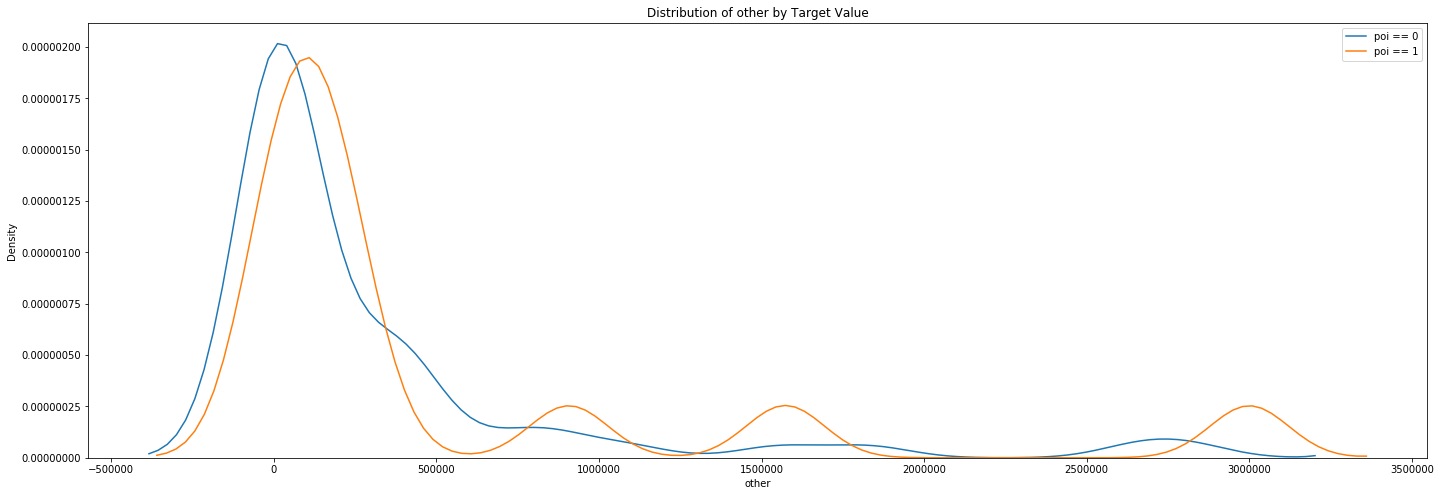

feat_label  poi


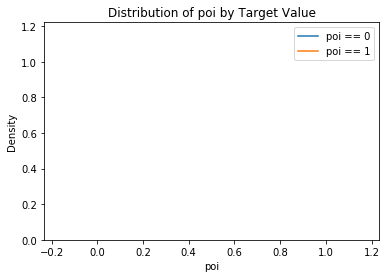

In [20]:
df_cp = df_train_tmp[ext_data_corrs_index]

df_cp['other'] = df_cp['other'].clip(0, 0.3*(10**7))


plot(df_cp[['other','poi']])


feat_labels  Index(['total_payments', 'poi'], dtype='object')
feat_label  total_payments


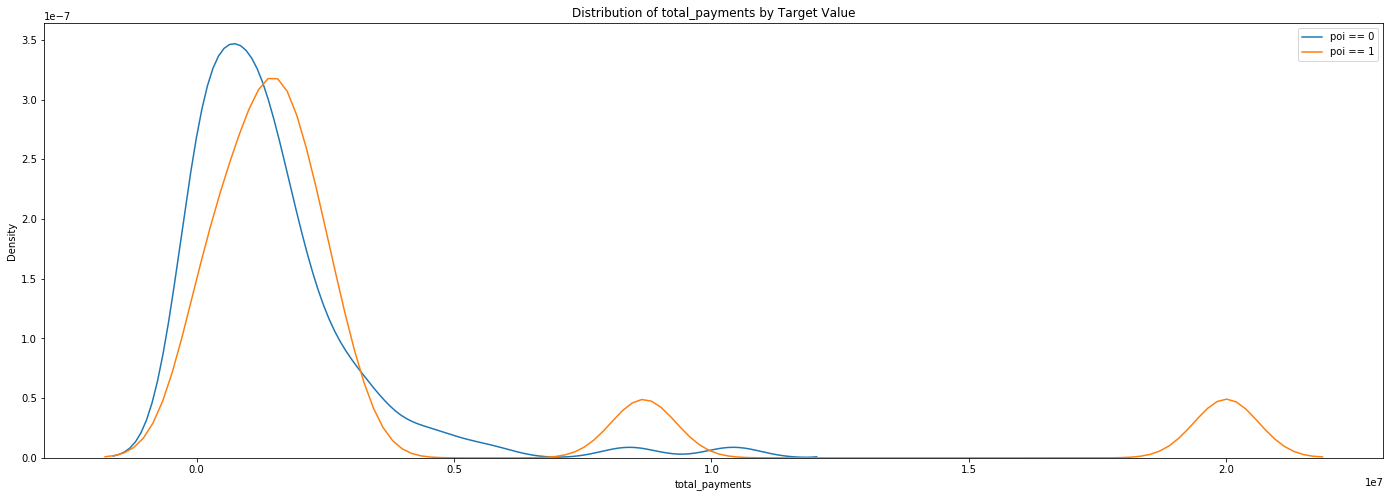

feat_label  poi


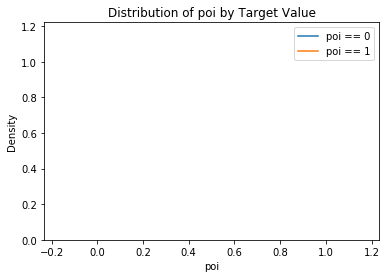

In [21]:

df_cp['total_payments'] = df_cp['total_payments'].clip(0, 0.2*(10**8))


plot(df_cp[['total_payments','poi']])